In [1]:
import codecs
import csv
import cStringIO
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plot_movies
import string
import sys
%matplotlib inline

from bokeh.io import output_notebook, show
output_notebook()

Loading BokehJS ...

In [5]:
def get_team_members(teamname):
    return [name for name, teamnames in credits_by_teams if teamname in teamnames]

with open('movies_6feb2017.json','rb') as infile:
    movie_dicts = json.load(infile)    
    
title, budget, gross, studio, rating, num_ratings, release_year = [], [], [], [], [], [], []
special_effects, visual_effects, animators, music = [], [], [], []

for movie in movie_dicts:
    if movie["title"] and int(movie["release_year"]) > 1979:
        title.append(movie["title"])
        release_year.append(int(movie["release_year"]))
           
        if movie["production_co"]:
            movie["production_co"] = movie["production_co"].replace('\n','')            
            studio.append(movie["production_co"].encode('utf-8'))
        else:
            studio.append("None")

        if movie["rating"] is None:
            movie["rating"] = 0            
        rating.append(float(movie["rating"]))

        if movie["num_ratings"]:
            movie["num_ratings"] = int(movie["num_ratings"].replace(',',''))
        elif movie["num_ratings"] is None:
            movie["num_ratings"]=0
        num_ratings.append(movie["num_ratings"])
                           
        if movie["gross"] is None:
            movie["gross"] = 0
        else:
            movie["gross"] = movie["gross"].strip()
            movie["gross"] = movie["gross"].replace(',','')
            movie["gross"] = movie["gross"].replace('$','')
        gross.append(float(movie["gross"])/1000000)
        
        credits_by_teams = movie["credits_by_teams"]
        visual_effects.append(len(get_team_members("Visual Effects by")))
        animators.append(len(get_team_members("Animation Department")))

In [6]:
ratio = []
for idx, val in enumerate(animators):
    if val == 0:
        ratio.append(0)
    else:
        ratio.append(float(visual_effects[idx])/val)

In [7]:
movie_df = pd.DataFrame({'title': title, 'Studio': studio, 'rating': rating, 'num_ratings': num_ratings, 
                         'gross': gross, 'ratio': ratio})
index_by_gross = movie_df.set_index(["gross"])
top50 = index_by_gross.sort_index(ascending = False).head(50)
top50.index.name = None
top100 = index_by_gross.sort_index(ascending = False).head(100)
top100.index.name = None
studio_gross_df = pd.pivot_table(movie_df, values='gross', index=['Studio'], aggfunc=np.sum)
studio_gross_df = studio_gross_df[studio_gross_df > 1000]

In [8]:
studio_gross_df

Studio
DreamWorks Animation               3747.045253
Pixar Animation Studios            2885.427315
Twentieth Century Fox Animation    1032.948077
Universal Pictures                 1379.682960
Walt Disney Pictures               3944.117172
Name: gross, dtype: float64

In [9]:
pixar = top50[top50.Studio == "Pixar Animation Studios"]
disney = top50[top50.Studio == "Walt Disney Pictures"]
dreamworks100 = top100[(top100.Studio == "DreamWorks") | (top100.Studio == "DreamWorks Animation")].head(20)

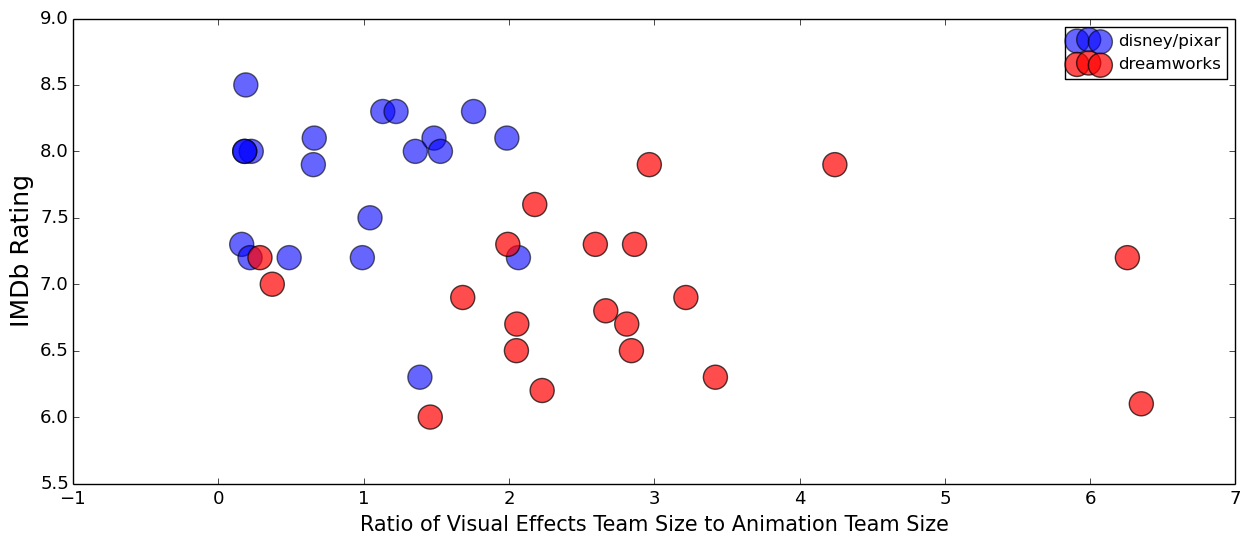

In [11]:
ax = pixar.reset_index().plot(x="ratio", y='rating', figsize = (15,6), kind='scatter', marker='o', s=300,
                               alpha = 0.6)
disney.reset_index().plot(x="ratio", y='rating', figsize = (15,6), kind='scatter', marker='o', s=300,  
                          label='disney/pixar', alpha = 0.6, ax=ax)
dreamworks100.reset_index().plot(x="ratio", y='rating', figsize = (15,6), kind='scatter', marker='o', s=300,
                              color='r', label='dreamworks', alpha = 0.7, ax=ax)
plt.xlabel('Ratio of Visual Effects Team Size to Animation Team Size',fontsize=15)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.ylabel('IMDb Rating', fontsize=18)

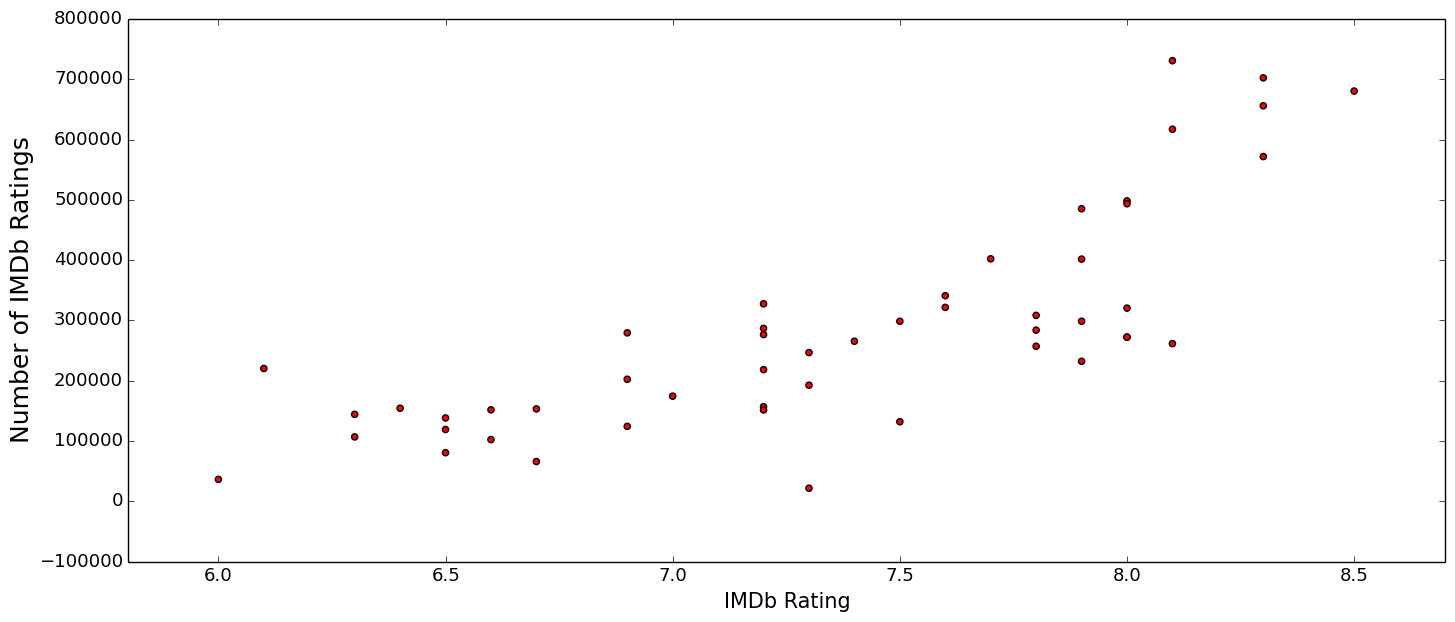

In [42]:
top50.reset_index().plot(x="rating", y='num_ratings', figsize = (17,7), kind='scatter', marker='o', color='r')
plt.xlabel('IMDb Rating',fontsize=15)
plt.xticks(fontsize=13)
plt.xlim([5.8 ,8.7])
plt.yticks(fontsize=13)
plt.ylabel('Number of IMDb Ratings', fontsize=18)

In [4]:
#show(plot_movies.make_interactive_plot())

In [3]:
#plot_movies.write_plot_html()